In [1]:
from dotenv import load_dotenv
from typing import List
import os
from tradesystem.adapters.clients import PolyMarketInfo
from tradesystem.adapters.markets.polymarket.polymarket_bet import PolyMarketBet_Crypto_Price_Bet, BetOutcome
from tradesystem.adapters.markets.binance.binance_btc_usd_spot import BinanceBTCUSDSpot
from tradesystem.adapters.markets.binance.binance_btc_usd_put_option import BinanceBTCUSDFuturePut
from tradesystem.strategies.put_spot_bet import PutSpotBet_ArbitrageStrategy
from tradesystem.domain.currencies import *

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json
import math

from tqdm import tqdm


In [2]:
SLUGS = ["what-price-will-bitcoin-hit-in-2025"]

TIMERANGE_TO_SEARCH_FOR_PUT = (datetime.fromisoformat("2025-12-25"),
                               datetime.fromisoformat("2025-12-27"))

## Load all polymarkets with the slug "what-price-will-bitcoin-hit-in-2025" 

In [3]:
btcEvent = PolyMarketInfo.get_events(slug = SLUGS[0], closed = "false")[0]

btcmarkets = [PolyMarketInfo.get_markets(id=market["id"])[0] for market in  btcEvent["markets"] if not market["closed"]]
btcmarkets = [market for market in btcmarkets if "dip" not in market['question'].lower()]

## Load all put options within a certain time period and a given stirke range

In [4]:
markets = []
for market in btcmarkets:
    markets.extend(PolyMarketBet_Crypto_Price_Bet.yes_and_now_from_api_market_dict(market))

markets : List[PolyMarketBet_Crypto_Price_Bet] = [market for market in markets if market.get_outcome() == BetOutcome.NO]

start = TIMERANGE_TO_SEARCH_FOR_PUT[0]
end   = TIMERANGE_TO_SEARCH_FOR_PUT[1]
putMarkets = BinanceBTCUSDFuturePut.get_all_available_put_options_for_filters(currency=CurrencyType.BTC, strike_range=(65000, 120000), closing_time_range=(start, end))

In [ ]:
GAIN_WHEN_BET_IS_LOST = 0.0025
CAPITAL = 10_000

print(f"Try to find arbitrage opportunities in {len(markets)} polymarkets x {len(putMarkets)} put option markets")

analysisResults = []
bitcoinSpot = BinanceBTCUSDSpot()

currentBtcPrice = bitcoinSpot.get_best_ask_price()
bitcoinPricesToCheck = np.arange(0.5*currentBtcPrice, 1.5*currentBtcPrice, 10)

for putM in tqdm(putMarkets):    
    for i, polyMarket in enumerate(markets):
        strategy = PutSpotBet_ArbitrageStrategy(capital_to_invest = CAPITAL, cryptoSpotMarket = bitcoinSpot, polyMarketBetCryptoPrice = polyMarket, cryptoPutMarket = putM, minrelativeGainWhenBetIsLost=GAIN_WHEN_BET_IS_LOST)
        analysisResults.append(strategy.calculate_profit_loss_curve(bitcoinPricesToCheck))

print(f"Found {len(analysisResults)} analysis results")
analysisResults = [res for res in analysisResults if res.get("arbitrage")]


Try to find arbitrage opportunities in 8 polymarkets x 12 put option markets


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]

Found 96 analysis results


## Payoff charts for all found arbitrage markets

* This chart shows the relative profit on the y-axis over all potential bitcoin prices on the x-axis.
* The red vertical line shows the current BTC price

#### Attention:

When investing in the proposed assets with the amount calculated, the following limit orders must be placed to avoid losses:

* BTC-Spotmarket: limit sell order at strike price of the polymarket bet
* If Expiration date of polymarket bet is after expiration date of put option, then btc spot investment should be sold if
    * put expires in the money (btc spot is under strike of put option)

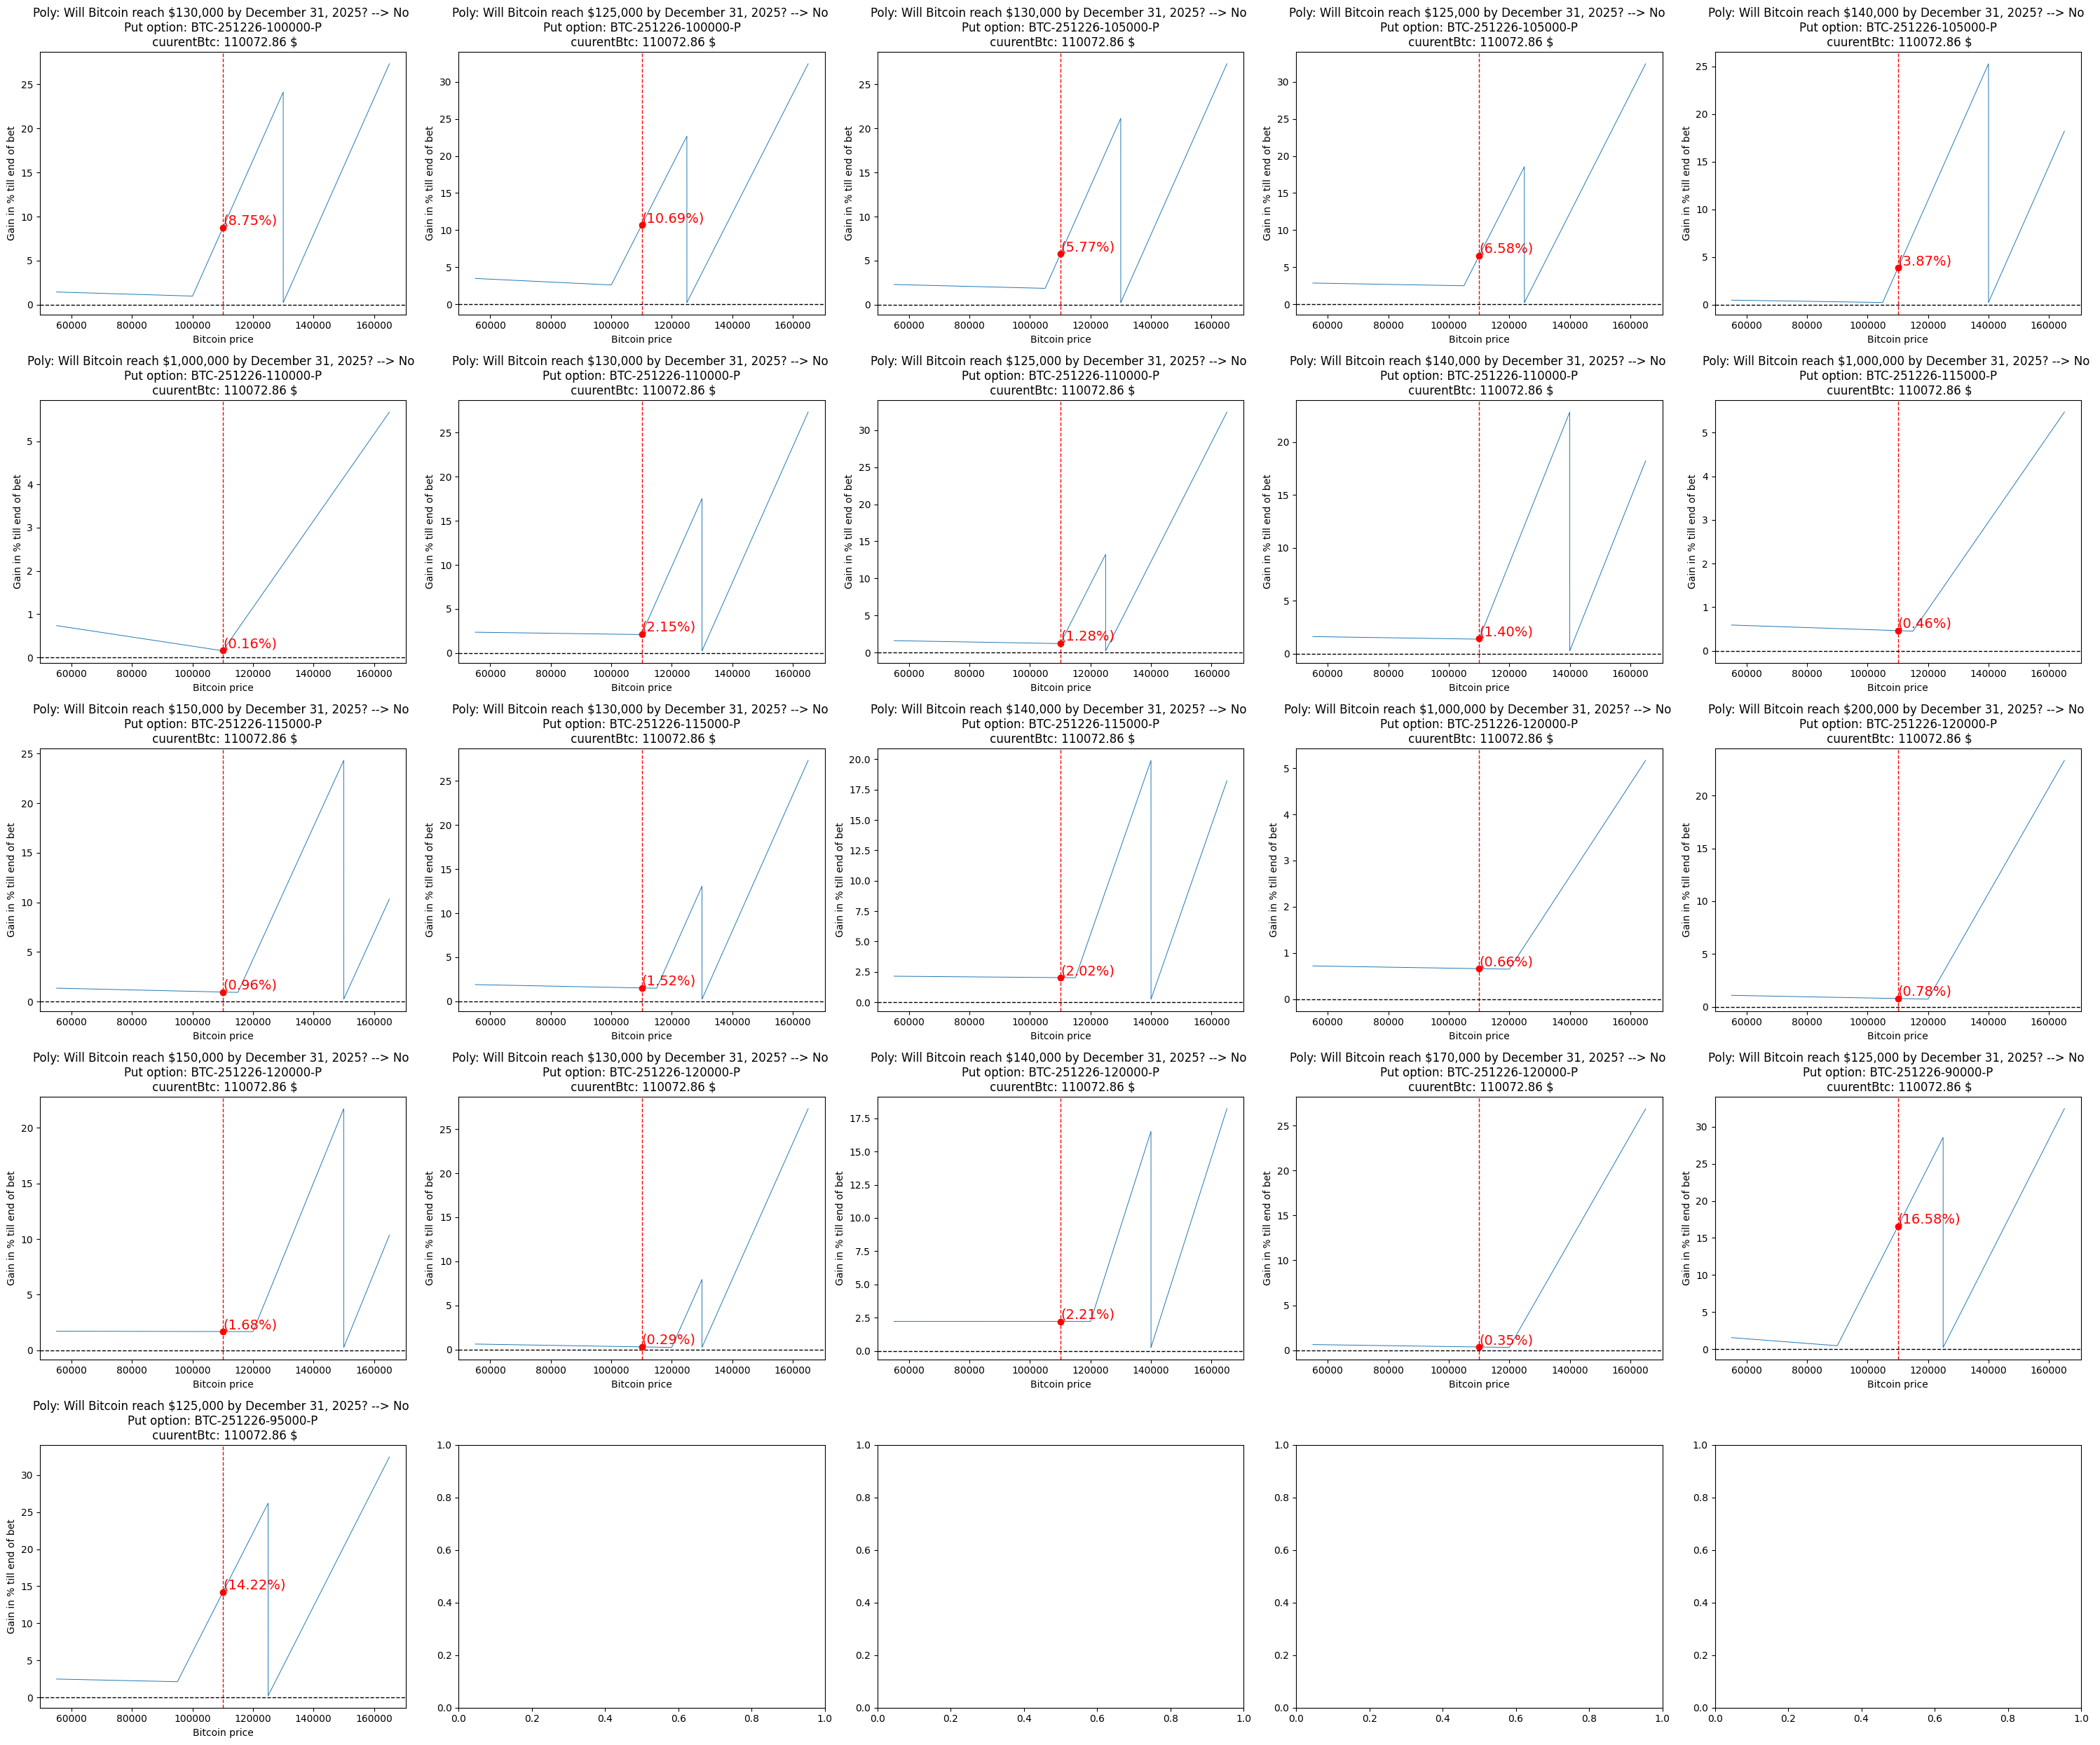

In [6]:
cols = math.ceil(math.sqrt(len(analysisResults)))
rows = math.ceil(len(analysisResults) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
axes = np.array(axes).reshape(-1)  # flatten, even if 1D
EXPECTED_PRICE_RANGE = [90000, 130000]


for i, res in enumerate(analysisResults):
    pay_off_curve = res.get("personalRelativeProfitDistribution")
    put_market = res.get("cryptoPutMarket")
    deltaInPercent = pay_off_curve * 100
    polyMarket = res.get("polyMarketBetCryptoPrice")

    axes[i].set_title(f"Poly: {polyMarket.question} --> No \nPut option: {put_market.symbol}\n cuurentBtc: {currentBtcPrice} $")

    # calculate profit for current buyin
    anual_profit_at_current_Price = np.interp(currentBtcPrice, bitcoinPricesToCheck, deltaInPercent)
    axes[i].scatter(currentBtcPrice, anual_profit_at_current_Price, color="red", zorder=5)
    axes[i].text(
        currentBtcPrice, anual_profit_at_current_Price,
        f"({anual_profit_at_current_Price:.2f}%)",
        color="red", fontsize=14, ha="left", va="bottom"
    )
    # plot all outcomes
    axes[i].plot(bitcoinPricesToCheck, deltaInPercent, linewidth=0.7)
    axes[i].axvline(x=currentBtcPrice, color="red", linestyle="--", linewidth=1)
    # axes[i].axvline(x=polyMarket.get_strike_price(), color="purple", linestyle="--", linewidth=1)
    axes[i].axhline(y=0, color="black", linestyle="--", linewidth=1)
    axes[i].set_xlabel("Bitcoin price")
    axes[i].set_ylabel("Gain in % till end of bet")

plt.tight_layout()
plt.show()

## Show details


In [7]:
SELECT = 0
selected = analysisResults[SELECT]


print(selected["polyMarketBetCryptoPrice"].question)
print(selected["cryptoPutMarket"].symbol)
print(f"currentSpotMarketPrice: {selected['currentSpotMarketPrice']}")

print()

print(f"to_be_invested_in_bet: {selected['to_be_invested_in_bet']}  --> if won: {selected['bet_value_if_won']}")
print(f"to_be_invested_in_put: {selected['to_be_invested_in_put']} --> get {selected['put_shares']} shares")
print(f"to_be_invested_in_spot: {selected['to_be_invested_in_spot']} --> get {selected['to_be_invested_in_spot'] / currentBtcPrice} btcs")

print(f"total investment: {selected['capital_invested']}")



Will Bitcoin reach $130,000 by December 31, 2025?
BTC-251226-100000-P
currentSpotMarketPrice: 110072.86

to_be_invested_in_bet: 168.2533598076924  --> if won: 357.9858719312604
to_be_invested_in_put: 58.5 --> get 0.011723446893787575 shares
to_be_invested_in_spot: 1273.2466401923075 --> get 0.011567307692307691 btcs
total investment: 1500


# Save the data from the calculation with the current date

In [8]:
# # Save orderbooks for later backtests
# ts = datetime.now().strftime("%y_%m_%d_%H_%M_%S")
# dirName = f"../.local/data/{ts}"
# os.makedirs(dirName, exist_ok=True)

# order_book_btc_spot = bitcoinSpot.get_order_book()
# order_book_btc_spot.save_order_book(prefix="btc_spot", dir=dirName)

# for putMarket in putMarkets:
#     order_book_put = putMarket.get_order_book()
#     order_book_put.save_order_book(prefix=putMarket.symbol, dir=dirName)

# for bet in markets:
#     order_book_bet = bet.get_order_book()
#     order_book_bet.save_order_book(prefix=bet.question, dir=dirName)

# fig.savefig(f"{dirName}/order_book_plots.png", dpi=300)

# blackListAnalysisKeys = ["cryptoPutMarket", "cryptoSpotMarket", "polyMarketBetCryptoPrice"] # exclude all market objects
# analysisResultsToSave = [{k:v for k,v in analysis.items() if k not in blackListAnalysisKeys} for analysis in analysisResults]

# print(analysisResultsToSave[0].keys())
# with open(f"{dirName}/analysisResults.json", 'w') as f:
#     f.write(json.dumps(analysisResultsToSave, default=lambda o: o.tolist() if isinstance(o, np.ndarray) else o, check_circular=False))